1.Imports and Setup: This section loads necessary libraries like PyTorch, NumPy, and Matplotlib. 
torch: This is the main PyTorch library. It provides support for tensors, which are multi-dimensional arrays optimized for deep learning computations and can be run on GPUs to accelerate processing.
torch.nn: This submodule of PyTorch contains classes and functions that help you create and train neural networks. It includes predefined layers, activation functions, and loss functions, among other necessary tools.
torch.utils.data: This submodule provides helpful utilities for handling datasets. It includes the Dataset and DataLoader classes, which are essential for batch processing and shuffling of data, making it easier to manage data in machine learning workflows.
Tensor: Specifically imported from torch, Tensor is the fundamental data structure of PyTorch. Tensors are similar to NumPy arrays but have additional capabilities that allow them to be used effectively in deep learning models.
numpy: This is a fundamental package for scientific computing with Python. It provides support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
matplotlib.pyplot: This is a plotting library used for creating static, interactive, and animated visualizations in Python. pyplot is a module in matplotlib that makes plotting simpler and similar to MATLAB's plotting system.

In [30]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

Prints the version of PyTorch that is currently being used. This is helpful for debugging and ensuring compatibility with various PyTorch features or third-party libraries.
Determines and sets the computing device for training neural network models. The device can either be a GPU or a CPU. Using a GPU (when available) is preferred because it significantly speeds up the training process of deep learning models due to its parallel processing capabilities. The code checks if a CUDA-capable GPU is available (torch.cuda.is_available()) and sets the device to GPU if possible, otherwise it falls back to using the CPU.
After determining the device, it prints out which device will be used. 

In [31]:
print("Using torch", torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # prefer gpu
print("Device", device)

Using torch 2.2.1+cu121
Device cuda


Dataset Class Definition: This defines a XORDataset class that inherits from PyTorch's data.Dataset. It is responsible for generating the XOR data along with added Gaussian noise based on a specified standard deviation. The class also contains methods to access the dataset length, individual items, and to convert the data to NumPy format for visualization.

In [ ]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1, device=device):
        """Make a random XOR data set.

        Args:
            size: Number of data points we want to generate
            std: Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)
        # Move data to GPU if relevant
        self.data = data.to(device)
        self.label = label.to(device)

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def toNumpy(self):
        return (self.data.cpu().numpy(), self.label.cpu().numpy()) # must be on cpy to convert to numpy

Visualization Function:The function visualize_binary_samples(dataset) is designed to visually represent a binary-labeled dataset in a scatter plot, which is particularly useful for understanding the distribution and structure of the data points in datasets like the one generated by XORDataset. 

Size of dataset: 200
Data point 0: (tensor([ 0.0758, -0.0238], device='cuda:0'), tensor(0, device='cuda:0'))


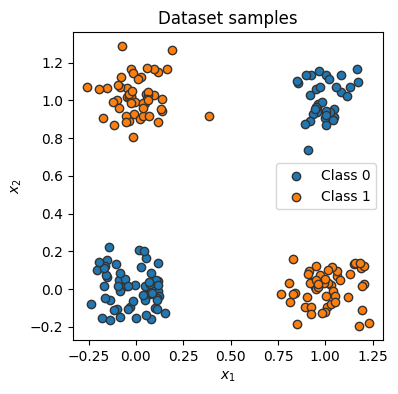

In [33]:
def visualize_binary_samples(dataset):
    """visualize a data set with binary labels.

    Args:
        data: the data set as, e.g., generated by XORDataset
    """
    (data,label) = dataset.toNumpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])
visualize_binary_samples(dataset)
plt.show()

Model Definition:The class SimpleClassifier which is a PyTorch module intended for creating a neural network designed to handle binary classification tasks, such as the noisy XOR problem. The module also includes functions to train and evaluate such a network. This section defines functions to train the model (train_model) and evaluate its performance (eval_model). These handle the process of running forward passes, backpropagation, updating model parameters, and calculating accuracy.

In [34]:
class SimpleClassifier(nn.Module):
    def __init__(self, src, tg, depth, width, device=device):
        """Make a convolutional neural network. Last layer uses the identity transfer function, the rest use the tanh.

        Args:
            src: The number of input nodes
            tg: The number of output nodes
            depth: The number of hidden layers
            width: The width of the hidden layers
        """
        super().__init__()

        self.enc_sizes = [src, tg, depth, width]


        ###############################################################################################
        # Assignment: replace self.model with your code for a network src-width-width-...-tg network
        ###############################################################################################
        layers = [nn.Linear(src, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers.extend([nn.Linear(width, width), nn.Tanh()])
        layers.append(nn.Linear(width, tg))
        # Identity layer is optional if you are using an output layer of one unit with BCEWithLogitsLoss
        layers.append(nn.Identity())
        self.model = nn.Sequential(*layers) #unpacking with the '*' operator

        # Move data to GPU if relevant
        self.model.to(device)

    def forward(self, x):
        x = self.model(x)
        x = x.squeeze(dim=1) # flat

        return x

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    """Train a model.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        data_loader: The function to load the data
        loss_module: The function to evaluate the loss function
        num_epochs: The number of epochs to train
    """
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            # Step 1: Run the model on the input data
            preds = model(data_inputs)
            #preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 2: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 3: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 4: Update the parameters
            optimizer.step()

def eval_model(model, data_loader):
    """Evaluate a model.

    Args:
        model: A (trained) model
        data_loader: The function to load the data
    """
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    return acc

In [35]:
import pandas as pd

loss_module = nn.BCEWithLogitsLoss()
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
results = []
depths = range(4)  # 0 to 3 layers
widths = range(1, 4)  # 1 to 3 units width
repetitions = 3  # Number of repetitions for each configuration



for depth in depths:
    for width in widths:
        accuracies = []
        for _ in range(repetitions):
            model = SimpleClassifier(src=2, tg=1, depth=depth, width=width).to(device)  # Ensure the model is on the correct device
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
            train_model(model, optimizer, train_data_loader, loss_module, num_epochs=200)
            acc = eval_model(model, test_data_loader)
            accuracies.append(acc.cpu().numpy())  # Move tensor to CPU and convert to numpy

        results.append({
            "Depth": depth,
            "Width": width,
            "Mean Accuracy": np.mean(accuracies),
            "Std Accuracy": np.std(accuracies)
        })

results_df = pd.DataFrame(results)
print(results_df)


    Depth  Width  Mean Accuracy  Std Accuracy
0       0      1       0.744000      0.002828
1       0      2       0.775333      0.174695
2       0      3       0.906000      0.132936
3       1      1       0.664667      0.115023
4       1      2       0.810667      0.134237
5       1      3       0.901333      0.139536
6       2      1       0.742000      0.002828
7       2      2       1.000000      0.000000
8       2      3       1.000000      0.000000
9       3      1       0.585333      0.117851
10      3      2       0.825333      0.116463
11      3      3       0.915333      0.119737


In [36]:
def calculate_parameters(depth, width):
    parameters = 0
    if depth > 0:
        # First layer parameters
        parameters += 2 * width + width
        # Hidden layers parameters
        for _ in range(depth - 1):
            parameters += width * width + width
        # Output layer parameters
        parameters += width * 1 + 1
    else:
        # No hidden layers, directly from input to output
        parameters += 2 * 1 + 1
    return parameters

# Print parameters for each configuration
for depth in range(4):  # Depths 0 to 3
    for width in range(1, 4):  # Widths 1 to 3
        params = calculate_parameters(depth, width)
        print(f"Depth: {depth}, Width: {width}, Parameters: {params}")


Depth: 0, Width: 1, Parameters: 3
Depth: 0, Width: 2, Parameters: 3
Depth: 0, Width: 3, Parameters: 3
Depth: 1, Width: 1, Parameters: 5
Depth: 1, Width: 2, Parameters: 9
Depth: 1, Width: 3, Parameters: 13
Depth: 2, Width: 1, Parameters: 7
Depth: 2, Width: 2, Parameters: 15
Depth: 2, Width: 3, Parameters: 25
Depth: 3, Width: 1, Parameters: 9
Depth: 3, Width: 2, Parameters: 21
Depth: 3, Width: 3, Parameters: 37
